In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [24]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('NSE-Tata-Global-Beverages-Limited.csv')
stock_data

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
...,...,...,...,...,...,...,...,...
1230,2013-10-14,160.85,161.45,157.70,159.30,159.45,1281419.0,2039.09
1231,2013-10-11,161.15,163.45,159.00,159.80,160.05,1880046.0,3030.76
1232,2013-10-10,156.00,160.80,155.85,160.30,160.15,3124853.0,4978.80
1233,2013-10-09,155.70,158.20,154.15,155.30,155.55,2049580.0,3204.49


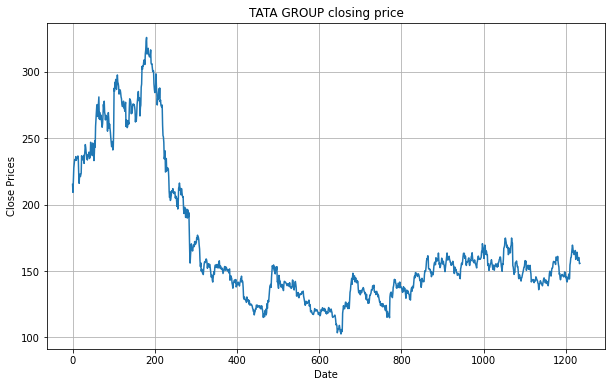

In [25]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('TATA GROUP closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

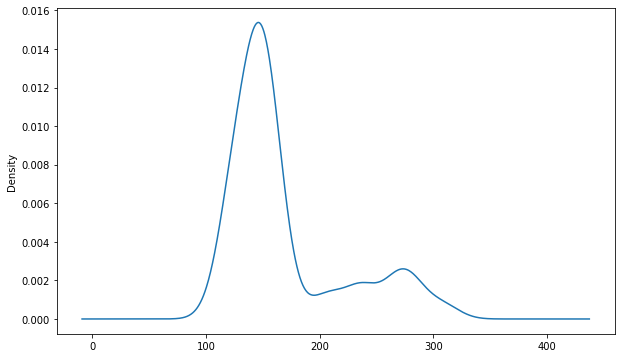

In [26]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

In [27]:
stock_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

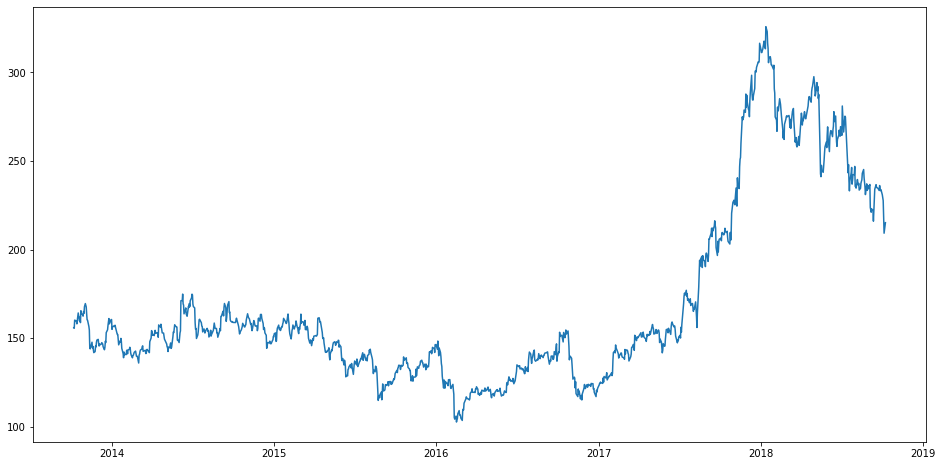

In [29]:
stock_data["Date"]=pd.to_datetime(stock_data.Date,format="%Y-%m-%d")
stock_data.index=stock_data['Date']
plt.figure(figsize=(16,8))
plt.plot(stock_data["Close"],label='Close Price history')

In [30]:
data=stock_data.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(stock_data)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [55]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2013-10-08,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
2013-10-09,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2013-10-10,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
2013-10-11,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
2013-10-14,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


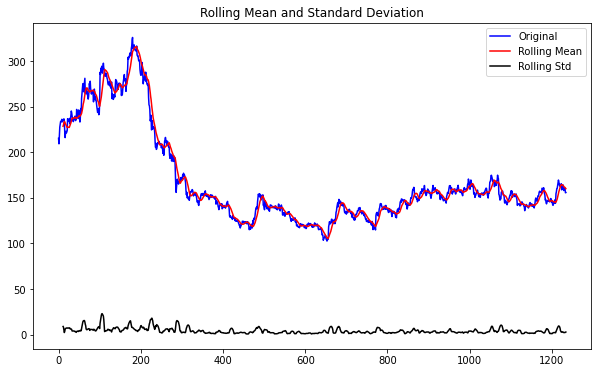

Results of dickey fuller test
Test Statistics                  -1.324698
p-value                           0.617799
No. of lags used                 16.000000
Number of observations used    1218.000000
critical value (1%)              -3.435730
critical value (5%)              -2.863916
critical value (10%)             -2.568035
dtype: float64


In [31]:
#Test for stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


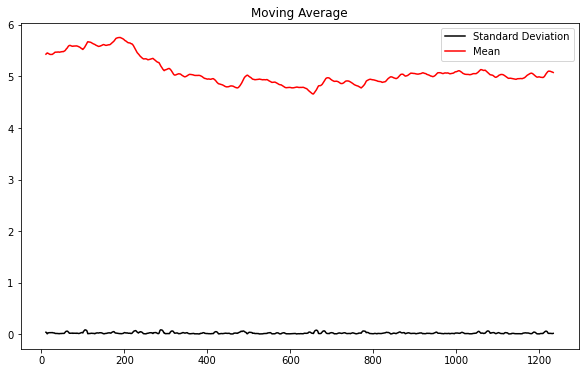

In [32]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [56]:
train_data, test_data = data[1:983], data[983:]
# plt.figure(figsize=(10,6))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Closing Prices')
# plt.plot(df_log, 'green', label='Train data')
# plt.plot(test_data, 'blue', label='Test data')
# plt.legend()

In [9]:
import statsmodels.api as sm

In [57]:
train_data

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2013-10-09,2013-10-09,155.70,158.20,154.15,155.30,155.55,2049580.0,3204.49
2013-10-10,2013-10-10,156.00,160.80,155.85,160.30,160.15,3124853.0,4978.80
2013-10-11,2013-10-11,161.15,163.45,159.00,159.80,160.05,1880046.0,3030.76
2013-10-14,2013-10-14,160.85,161.45,157.70,159.30,159.45,1281419.0,2039.09
2013-10-15,2013-10-15,160.00,160.20,155.35,157.10,158.05,1145582.0,1805.49
...,...,...,...,...,...,...,...,...
2017-09-25,2017-09-25,201.45,202.00,192.30,197.00,196.65,4019965.0,7877.39
2017-09-26,2017-09-26,196.00,206.45,195.30,204.95,204.65,5546594.0,11185.50
2017-09-27,2017-09-27,206.50,207.00,196.65,198.50,198.60,3331256.0,6727.73


In [58]:
train_data.dtypes

Date                    datetime64[ns]
Open                           float64
High                           float64
Low                            float64
Last                           float64
Close                          float64
Total Trade Quantity           float64
Turnover (Lacs)                float64
dtype: object

In [65]:
train_data.dtypes

Date                    datetime64[ns]
Open                           float64
High                           float64
Low                            float64
Last                           float64
Close                          float64
Total Trade Quantity           float64
Turnover (Lacs)                float64
dtype: object

In [66]:
train_data.set_index('Date',inplace=True)

In [68]:
b=np.array(train_data)

In [69]:
p=b.flatten()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=211335.613, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=211337.594, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=211337.595, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=211339.595, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=210761.474, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=210712.894, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=210652.180, Time=0.35 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=210577.478, Time=0.48 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=210564.055, Time=2.92 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=210662.765, Time=2.29 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=15.69 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=209418.869, Time=18.72 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=210328.228, Time=4.11 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=213183.709, Time=9.50 sec
 ARIMA(1,0

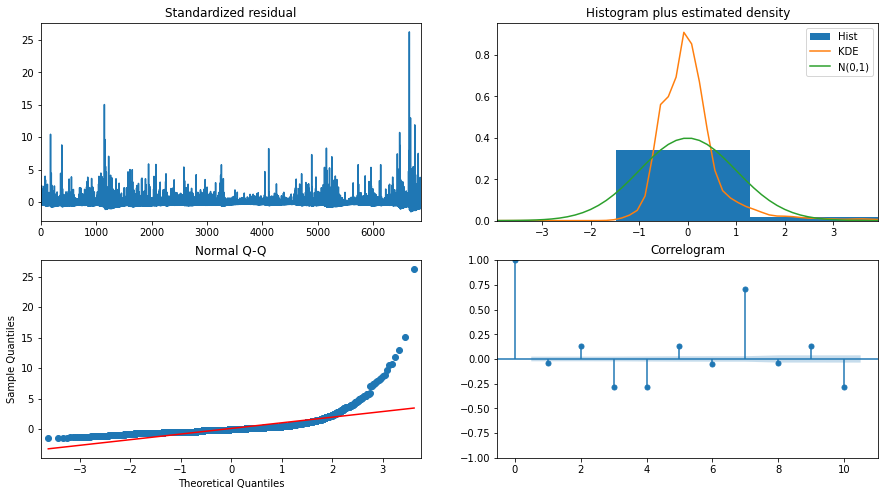

In [70]:
model_autoARIMA = auto_arima(p, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [39]:
stock_data.dtypes

Date                    datetime64[ns]
Open                           float64
High                           float64
Low                            float64
Last                           float64
Close                          float64
Total Trade Quantity           float64
Turnover (Lacs)                float64
dtype: object

In [54]:
stock_data.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [59]:
data.set_index('Date',inplace=True)

In [60]:
data.dtypes

Open                    float64
High                    float64
Low                     float64
Last                    float64
Close                   float64
Total Trade Quantity    float64
Turnover (Lacs)         float64
dtype: object

In [71]:
model_autoARIMA.fit(p)

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)

In [72]:
prediction = pd.DataFrame(model_autoARIMA.predict(n_periods = 252),index=test_data.index)
prediction.columns = ['predicted_sales']
prediction

,predicted_sales
Date,
2017-10-03,-9.460723e+05
2017-10-04,9.965958e+05
2017-10-05,1.043352e+06
2017-10-06,-9.155097e+05
2017-10-09,-9.208923e+04
...,...
2018-10-01,8.689320e+05
2018-10-03,-6.102992e+05
2018-10-04,-5.364481e+04
